In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

# from pushover import notify
# from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu' ## don't know why the performance is very poor in GPU

In [132]:
batch_size = 32
download_dataset = False

In [133]:
# Load Data
train_dataset = datasets.MNIST(root='./MNIST', download=True, train=True,
                                transform=transforms.Compose([
#                                     transforms.Resize(64), 
                                    transforms.ToTensor()
                                ])
                              )
test_dataset = datasets.MNIST(root='./MNIST', download=True, train=False,
                             transform=transforms.Compose([
                                 transforms.ToTensor()
                             ]))

In [134]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=32, shuffle=True,
                                              num_workers=1, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=32, shuffle=True,
                                              num_workers=1, pin_memory=True)

In [135]:
datasets.MNIST(root='./MNIST', download=True, train=True)[0][0]

In [136]:
image_channels = train_dataset[0][0].shape[0]

## Define VAE Structure

In [137]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [138]:
class UnFlatten(nn.Module):
    def forward(self, input, size=256):
        return input.view(input.size(0), size, 1, 1)

In [139]:
class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=256, z_dim=16):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            # 1 * 28 * 28
            nn.Conv2d(in_channels=image_channels, out_channels=16, 
                      kernel_size=4, stride=2),
            nn.ReLU(),
            # 16 * 13 * 13
            nn.Conv2d(in_channels=16, out_channels=32,
                      kernel_size=3, stride=2),
            nn.ReLU(),
            # 32 * 6 * 6
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=3, stride=1),
            nn.ReLU(),
            # 64 * 4 * 4
            nn.Conv2d(in_channels=64, out_channels=256, 
                      kernel_size=4, stride=1),
            nn.ReLU(),
            # 256 * 1 * 1
            Flatten()
            # 256
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim) # for mu
        self.fc2 = nn.Linear(h_dim, z_dim) # for sigma
        self.fc3 = nn.Linear(z_dim, h_dim) # for decoder
        
        self.decoder = nn.Sequential(
            # 256
            UnFlatten(),
            # 256 * 1 * 1
            nn.ConvTranspose2d(h_dim, 64, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, image_channels, kernel_size=4, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return std
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [140]:
model = VAE(image_channels=image_channels).to(device)
model

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 256, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): Flatten()
  )
  (fc1): Linear(in_features=256, out_features=16, bias=True)
  (fc2): Linear(in_features=256, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=256, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(1, 1))
    (2): ReLU()
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2))
    (8): Sigmoid()
  )
)

## Define loss function

In [141]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

## Do optimization to train NN

In [150]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 

device(type='cuda')

In [152]:
EPOCH = 50
for epoch in range(EPOCH):
    for idx, (images, _) in enumerate(train_dataloader):
        images = images.to(device)
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, EPOCH,
                        loss.data.item()/batch_size,
                        bce.data.item()/batch_size, 
                        kld.data.item()/batch_size)
    print(to_print)

torch.save(model.state_dict(), 'vae.torch')

Epoch[1/50] Loss: 67.177 67.174 0.003
Epoch[2/50] Loss: 63.341 63.337 0.004
Epoch[3/50] Loss: 58.055 58.052 0.003
Epoch[4/50] Loss: 60.531 60.528 0.003
Epoch[5/50] Loss: 51.421 51.417 0.004
Epoch[6/50] Loss: 59.297 59.293 0.004
Epoch[7/50] Loss: 57.840 57.837 0.003
Epoch[8/50] Loss: 57.688 57.686 0.003
Epoch[9/50] Loss: 62.302 62.299 0.003
Epoch[10/50] Loss: 63.979 63.976 0.003
Epoch[11/50] Loss: 61.983 61.980 0.003
Epoch[12/50] Loss: 56.750 56.747 0.003
Epoch[13/50] Loss: 57.331 57.328 0.003
Epoch[14/50] Loss: 62.135 62.133 0.003
Epoch[15/50] Loss: 66.832 66.829 0.003
Epoch[16/50] Loss: 64.497 64.494 0.003
Epoch[17/50] Loss: 55.255 55.252 0.003
Epoch[18/50] Loss: 60.801 60.798 0.003
Epoch[19/50] Loss: 62.686 62.683 0.003
Epoch[20/50] Loss: 63.317 63.314 0.003
Epoch[21/50] Loss: 60.593 60.590 0.003
Epoch[22/50] Loss: 61.680 61.677 0.003
Epoch[23/50] Loss: 58.828 58.826 0.002
Epoch[24/50] Loss: 59.289 59.286 0.003
Epoch[25/50] Loss: 62.936 62.934 0.003
Epoch[26/50] Loss: 59.757 59.755 0

## test VAE

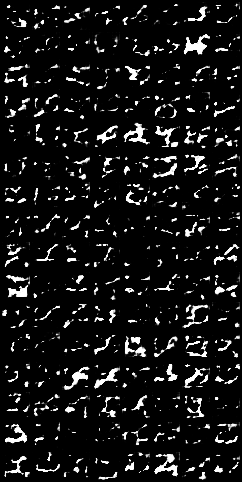

In [154]:
sample = Variable(torch.randn(128,16))
recon_x = model.decode(sample.to(device))
# recon_x, _, _ = vae(fixed_x)

save_image(recon_x.view(recon_x.size(0), 1, 28, 28).data, 'sample_image.png')
Image('sample_image.png')

## FDD via VAE

In [155]:
len(test_dataset)

10000

### how can VAE do the reconstruction task

In [156]:
rand_index = torch.randint(0,len(test_dataset),(64,))
test_tensor = torch.stack([test_dataset[i][0].clone() for i in rand_index])
recon_tensor = model(test_tensor)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [ ]:
save_image(test_tensor.view(test_tensor.size(0), 1, 28, 28).data, 'test_image_orig.png')
Image('test_image_orig.png')

In [ ]:
save_image(recon_tensor[0].view(recon_tensor[0].size(0), 1, 28, 28).data, 'test_image_recon.png')
Image('test_image_recon.png')

### check the ecoded results

In [ ]:
test_z, test_mu, test_logvar = model.encode(test_tensor[torch.randint(0,len(rand_index),(1,))])
test_mu